# Understanding "group by", "filter", "transform"

In [1]:
# numpy
import numpy as np
# Matplotlib, inline so that the plots appear inline in notebook
# rather than in a separate window
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# pandas
import pandas as pd

In [2]:
# define a toy data frame
np.random.seed(seed = 1234)
tmp = pd.DataFrame(np.random.randint(0, 100, (10, 5)),
                   columns=['a', 'b', 'c', 'd', 'e'])
tmp['group'] = ['g1', 'g1', 'g1', 'g2', 'g2', 'g2', 'g3', 'g3', 'g3', 'g3']
print(tmp)

    a   b   c   d   e group
0  47  83  38  53  76    g1
1  24  15  49  23  26    g1
2  30  43  30  26  58    g1
3  92  69  80  73  47    g2
4  50  76  37  34  38    g2
5  67  11   0  75  80    g2
6   3   2  19  12  65    g3
7  75  81  14  71  60    g3
8  46  28  81  87  13    g3
9  96  12  69  95  31    g3


In [3]:
# group by the "group" variable
tmp_grouped = tmp.groupby('group')
# look at how the rows are grouped together
tmp_grouped.groups

{'g1': [0, 1, 2], 'g2': [3, 4, 5], 'g3': [6, 7, 8, 9]}

In [4]:
# take the mean within each group
print(tmp_grouped.sum())

         a    b    c    d    e
group                         
g1     101  141  117  102  160
g2     209  156  117  182  165
g3     220  123  183  265  169


What is the **apply** function doing below?

In [6]:
def my_fun(df):
    if np.sum(df['a']) < 210:
        print('df: \n', df)
    return df


tmp_grouped.apply(my_fun)

df: 
     a   b   c   d   e
0  47  83  38  53  76
1  24  15  49  23  26
2  30  43  30  26  58
df: 
     a   b   c   d   e
0  47  83  38  53  76
1  24  15  49  23  26
2  30  43  30  26  58
df: 
     a   b   c   d   e
3  92  69  80  73  47
4  50  76  37  34  38
5  67  11   0  75  80


,a,b,c,d,e
0,47,83,38,53,76
1,24,15,49,23,26
2,30,43,30,26,58
3,92,69,80,73,47
4,50,76,37,34,38
5,67,11,0,75,80
6,3,2,19,12,65
7,75,81,14,71,60
8,46,28,81,87,13
9,96,12,69,95,31


In [9]:
tmp_grouped.count()

,a,b,c,d,e
group,,,,,
g1,3,3,3,3,3
g2,3,3,3,3,3
g3,4,4,4,4,4


In [13]:
tmp_grouped.apply(np.mean, axis = 0) 

,a,b,c,d,e
group,,,,,
g1,33.666667,47.00,39.00,34.000000,53.333333
g2,69.666667,52.00,39.00,60.666667,55.000000
g3,55.000000,30.75,45.75,66.250000,42.250000


## Obtaining the terminal digits from each of the counts

In [7]:
tmp

,a,b,c,d,e,group
0,47,83,38,53,76,g1
1,24,15,49,23,26,g1
2,30,43,30,26,58,g1
3,92,69,80,73,47,g2
4,50,76,37,34,38,g2
5,67,11,0,75,80,g2
6,3,2,19,12,65,g3
7,75,81,14,71,60,g3
8,46,28,81,87,13,g3
9,96,12,69,95,31,g3


In [8]:
def terminal_digit(a):
    return a % 10

tmp.drop('group', 1).apply(terminal_digit)

,a,b,c,d,e
0,7,3,8,3,6
1,4,5,9,3,6
2,0,3,0,6,8
3,2,9,0,3,7
4,0,6,7,4,8
5,7,1,0,5,0
6,3,2,9,2,5
7,5,1,4,1,0
8,6,8,1,7,3
9,6,2,9,5,1


# Calculating the MLE of a poisson model

In [16]:
import scipy.optimize
import scipy.misc

def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return np.exp(-lamb) * (lamb ** k / scipy.misc.factorial(k))

def log_poisson_better(k, lamb):
    """better poisson pdf, avoid overflow"""
    p = - lamb + k * np.log(lamb)
    for i in range(k):
        p -= np.log(i+1)
    return p


def neg_log_likelihood(params, data):
    """ the negative log-Likelohood-Function"""
    # the following line will overflow
    # l = - np.mean(np.log(poisson, data, params[0]))
    l = - np.mean(data.apply(lambda x: log_poisson_better(x, params[0])))
    return l


In [17]:
pois_dat = pd.DataFrame(np.random.poisson(20,100), columns = ['a'])['a']

result = scipy.optimize.minimize(neg_log_likelihood,  # function to minimize
                  x0=np.ones(1),     # start value
                  args=(pois_dat,),      # additional arguments for function
                  method='Powell',   # minimization method, see docs
                  )
# result is a scipy optimize result object, the fit parameters 
# are stored in result.x
print(result)


   direc: array([[-0.0193327]])
     fun: array(2.882561653485624)
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 2
  status: 0
 success: True
       x: array(19.29000000921598)


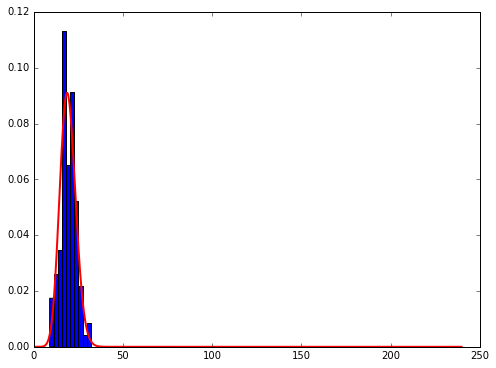

In [18]:
# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 300, 1000)
plt.figure(figsize=(8, 6))
plt.hist(pois_dat, bins=10, normed=True)
plt.plot(x_plot, poisson(x_plot, result.x), 'r-', lw=2)
plt.show()